# Experiment: correlation length on background subtraction

We want to see how the length of the circular buffer, the length of the temporal seperation, and the method of background subtraction affects the correlation post-subtrraction plots.

In [2]:
# imports
import numpy as np
import pandas as pd
import numpy.ma as ma
import importlib
import matplotlib
from astropy.stats import sigma_clipped_stats
from importlib import reload
import time
from astropy.io import fits

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#personal
from pipeline.est_pipeline import *
from pipeline.code.file_reader import *
from pipeline.code.corr_plots import *
from pipeline.code.cluster import *

import pipeline.code.Estimator as es
import pipeline.code.Estimator_R as er
#import pipeline.code.data_table as d_t
import pipeline.code.graph_code as gc
import pipeline.code.corr_plots as cp
import pipeline.code.corr_code as cc

import pipeline.code.Correlator as Cor
from importlib import reload

# Long AOCBs now short

### Pulling long and short files

In [3]:

dates = ['20210429', '20210430', '20210501', '20210502']
fts_f = []
count_lst = [0]

for d in dates:
    p = f'/home/emcewen/out/{d}/fits/'
    files = os.listdir(p)
    lgth_fits = [p + fn for fn in files if fnmatch.fnmatch(fn, '*tmax1000_tts_f0*.fits')]
    fts_f.extend(lgth_fits)
    count_lst.append(len(lgth_fits) + count_lst[-1])
    
fts_f.sort()

In [11]:
# old files: 
fts_f_o = []
count_lst_o = [0]

for d in dates:
    p = f'/home/emcewen/out/{d}/fits/'
    files = os.listdir(p)
    lgth_fits = [p + fn for fn in files if fnmatch.fnmatch(fn, '*tmax1000_tts.fits')]
    fts_f_o.extend(lgth_fits)
    count_lst_o.append(len(lgth_fits) + count_lst_o[-1])
    
fts_f_o.sort()

### what do their decays look like?

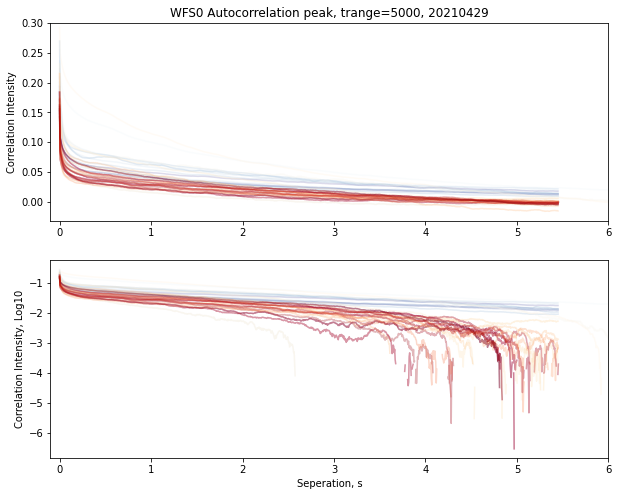

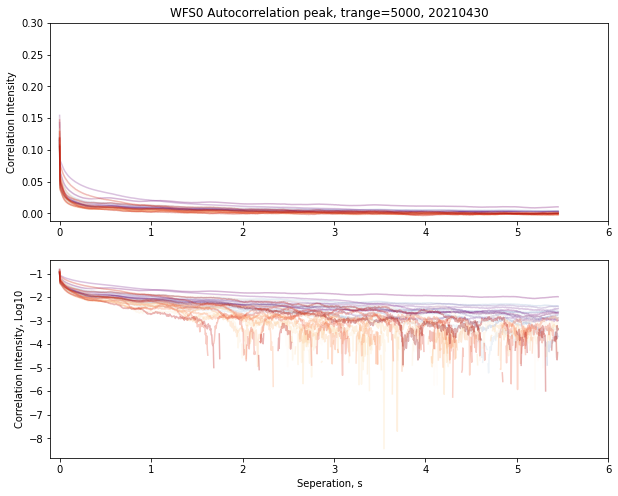

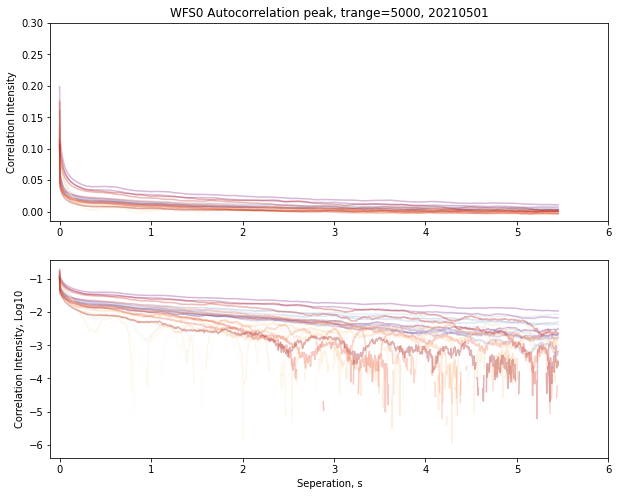

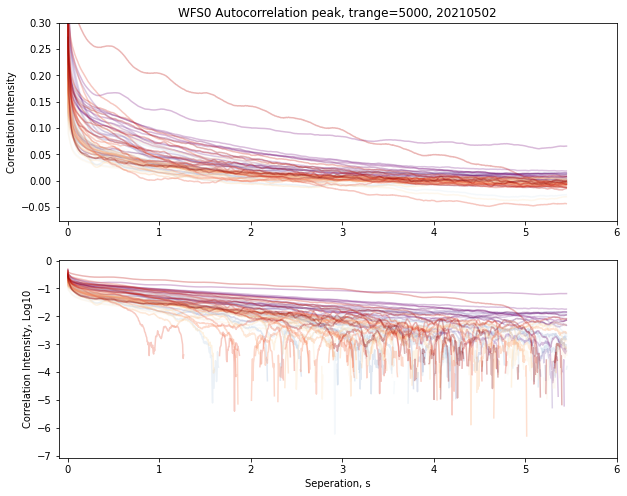

In [14]:
# for each date, plot
cmap = matplotlib.cm.get_cmap('OrRd')
cmap_o = matplotlib.cm.get_cmap('BuPu')

for i, d in enumerate(dates):
    fig, ax =  plt.subplots(2,1,figsize=(10,8))
    ax[0].set_ylabel('Correlation Intensity')
    ax[1].set_ylabel('Correlation Intensity, Log10')
    ax[1].set_xlabel('Seperation, s')
    ax[0].set_title(f'WFS0 Autocorrelation peak, trange=5000, {d}')
    
    # fiding files for this date:
    files_tmp = fts_f[count_lst[i]:count_lst[i+1]]
    files_tmp_o = fts_f_o[count_lst_o[i]:count_lst_o[i+1]]
    f_list = len(files_tmp)
    f_list_o = len(files_tmp_o)
    
    # for each file, pull one wfs, plot on 
    for c, f in enumerate(files_tmp_o):
        pull_data = Cor.Correlator("", "", "", f_file = f)
        avg_acor = (pull_data.acor_x + pull_data.acor_y)/2
        center_peak_0 = avg_acor[0, :, 7, 7] # takes just WFS 0 peak
        t_coords = np.arange(center_peak_0.shape[0]) # this is the time in frames
        t_coords = t_coords / pull_data.hz_pull()
        
        ax[0].plot(t_coords, center_peak_0, c=cmap_o(c/f_list_o), alpha=0.3)
        ax[1].plot(t_coords, np.log10(center_peak_0), c=cmap_o(c/f_list_o), alpha=0.3)     
        
    # for each file, pull one wfs, plot on 
    for c, f in enumerate(files_tmp):
        pull_data = Cor.Correlator("", "", "", f_file = f)
        avg_acor = (pull_data.acor_x + pull_data.acor_y)/2
        center_peak_0 = avg_acor[0, :, 7, 7] # takes just WFS 0 peak
        t_coords = np.arange(center_peak_0.shape[0]) # this is the time in frames
        t_coords = t_coords / pull_data.hz_pull()
        
        ax[0].plot(t_coords, center_peak_0, c=cmap(c/f_list), alpha=0.3)
        ax[1].plot(t_coords, np.log10(center_peak_0), c=cmap(c/f_list), alpha=0.3)
            
    ax[0].set_ylim(top=0.3)
    ax[0].set_xlim(left=-0.1, right=6)
    ax[1].set_xlim(left=-0.1, right=6)
    plt.show()

### Fit their AOCBs

In [15]:
# Trying to save parameters,
# Shorter AOCB

import t_const_code as tc
reload(tc)

ln = 300

f1_lst = []
# Calculating fit parameters for all files, average per aocb
for file in fts_f:
    try:
        center_avg, t, f1 = tc.decay_fn_2(file, 600, c_min = 50, c_max = ln)
        f1_lst.append(f1[:2])
    except:
        print('error with file: ', file)
        f1_lst.append(np.zeros(2)) # files with errors sent to 0
f1_lst = np.array(f1_lst)

In [24]:
## LOnger AOCBS at the same time
f1_lst_o = []
# Calculating fit parameters for all files, average per aocb
for file in fts_f_o:
    try:
        center_avg, t, f1 = tc.decay_fn_2(file, 600, c_min = 50, c_max = ln)
        f1_lst_o.append(f1[:2])
    except:
        print('error with file: ', file)
        f1_lst_o.append(np.zeros(2)) # files with errors sent to 0
f1_lst_o = np.array(f1_lst_o)

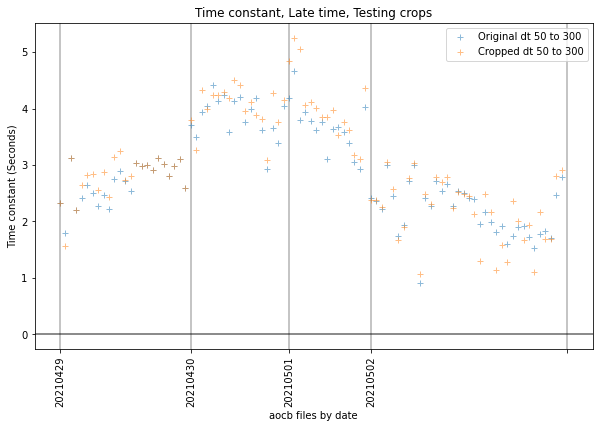

In [38]:
# plotting all time coefficients, one length 
plt.figure(figsize=(10,6))
color_list = ["r", "b", "cyan"]
plt.title("Time constant, Late time, Testing crops")

for c in count_lst:
    plt.axvline(c, c="black", alpha = 0.3)
    
plt.plot(-f1_lst_o[:,1], '+', alpha = 0.5, label = f"Original dt 50 to {ln}")
plt.plot(-f1_lst[:,1], '+', alpha = 0.5, label = f"Cropped dt 50 to {ln}")

plt.axhline(0, c="black", alpha = 0.6)
    
plt.xticks(count_lst, dates, rotation ='vertical') 
plt.ylabel('Time constant (Seconds)')
plt.xlabel('aocb files by date')
plt.legend()
#plt.ylim(-0.5, 4)
plt.show()

In [ ]:
# example AOCB?

# Older work (pre 11/2021)

In [3]:
out_dir = "/home/emcewen/code_dev/test/test_lengths/"
data_path = "/home/imaka/data/"

# aocb file:
date = '20210503'
aocb = 'aocb0001o'

# file things
name = f'{date}_{aocb}'
file_path = f'{data_path}{date}/ao/{aocb}.fits'

In [4]:
#Creating list of all corr files
dates = ['20180531', '20180601', '20181219', '20181221', '20181222', '20181223', '20210429', '20210430', '20210501', '20210502']
fts_f = []
count_lst = [0]

for d in dates:
    p = f'/home/emcewen/out/{d}/fits/'
    files = os.listdir(p)
    lgth_fits = [p + fn for fn in files if fnmatch.fnmatch(fn, '*tmax1000_tts.fits')]
    fts_f.extend(lgth_fits)
    count_lst.append(len(lgth_fits) + count_lst[-1])
    
fts_f.sort()

## Basic Correlation things

A few quick reminders on how to access correlation files and such

In [135]:
# Quick simulation run
reload(Cor)
# init object
curr_data = Cor.Correlator(name, file_path, out_dir, tmax=100, s_sub=True, tt_sub=True)

# set the range
curr_data.set_trange([0, 100])
#check that the slopes are the right length:
curr_data.x_slopes.shape

(5, 100, 8, 8)

In [ ]:
# pullign a correlation fits and animating it

p_file = "/home/emcewen/code_dev/test_lengths/fits/20210503_aocb0001o_tmax200_stt_0.fits"
pull_data = Correlator("", "", "", f_file = p_file)
pull_data.out_dir = out_dir
pull_data.cor_animate_all(dt_max=40, avg_sub=True, avg_len=200)

In [57]:
hdul = fits.open(file_path)
hdr = hdul[1].header
hdr

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =                    1 / length of data axis 1                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
TSTAMPA0=           2611200455 / Timestamp from camera #0 at first time step    
TSTAMPA1=           2611195565 / Timestamp from camera #1 at first time step    
TSTAMPA2=           2611195092 / Timestamp from camera #2 at first time step    
TSTAMPA3=           2611195585 / Timestamp from camera #3 at first time step    
TSTAMPA4=           42949672

## Part 0: Total integration time per file

In [61]:
hz_list = []
fram_list = []

for file in fts_f:
    # open fits file
    # collect number of frames and Hz
    hdul = fits.open(file)
    d_file = hdul[0].header["DATAFILE"]
    hdul.close()
    
    hdul = fits.open(d_file)
    hz = hdul[1].header["FSAMPLE0"]
    fram = hdul[0].header["NCB"]
    hdul.close()
    
    hz_list.append(hz)
    fram_list.append(fram)

In [66]:
count = 0
summ = 0
idx = 1

# Hz = frames/second
# frame  = frames

for i in range(len(hz_list)):
    if hz_list[i] > 0:
        summ += fram_list[i]/hz_list[i]
    count += 1
    
    if count == count_lst[idx]:
        print(dates[idx -1], summ)
        idx += 1
        summ = 0

20180531 806.3628107181485
20180601 2225.6059917366797
20181219 1637.2309694248993
20181221 1854.6955339010667
20181222 1749.8568110108147
20181223 5708.299259469856
20210429 2115.668715830853
20210430 2651.0404479194954
20210501 2209.4530907212043
20210502 3010.961463312736


## Part 1: different correlation lengths

1.A First, we will take one AOCB, and correlate different seperations. (100, 200, 400, 800, 1600, all)

1.B Second, we will cut an AOCB into different portions and correlate again (full 150s, 80s, 40s, 20s)

Compare!

In [ ]:
# did this with the function: test_lengths_script.py date_iter_short(tmax)

In [ ]:
# For a given aocb, does the center peak decay change?
test_dir_100 = "test_lengths/trange/fits/20210430_aocb0031o_tmax100_stt_"
suff = ".fits"
length_100 = ["f0_13500", "f13500_27000"]

test_dir = "test_lengths/trange/fits/20210430_aocb0031o_tmax2000_stt_"
length = ["f0_13500", "f0_f3375", "f0_5000", "f0_6750", "f3375_6750", "f6750_13500", "f13500_27000"]


## Part 2: different background subtractions

2.A Background subtractions at different lengths

2.B Background subtractions at different seperations away from start 


In [71]:
# Check out 
print([t for t in range(0, 1000, 200)])

[0, 200, 400, 600, 800]


<module 'matplotlib.pyplot' from '/home/emcewen/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

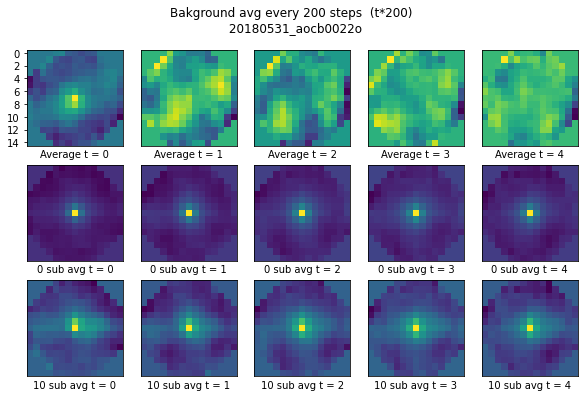

In [98]:
# plot: for one 1000 length file, background taken at 200 intervals
p_file = "/home/emcewen/out/20180531/fits/20180531_aocb0022o_tmax1000_tts.fits"

# pull file 
pull_data = Cor.Correlator("", "", "", f_file = p_file)
avg_acor = (pull_data.acor_x + pull_data.acor_y)/2
center_avg = np.average(avg_acor[:2], axis=(0))

tmax = 1000

background_cube = []
td0_cube = []
td10_cube = []


# take average at 200 increments
for t in range(0, tmax, 200):
    avg_tmp = np.average(center_avg[t:t+199], axis = 0)
    background_cube.append(avg_tmp)
    td0_cube.append(center_avg[0] - avg_tmp)
    td10_cube.append(center_avg[10] - avg_tmp)
    
t_list = np.arange(len(td10_cube))
    
graph_3_rows_t_mat(background_cube, td0_cube, td10_cube, t_list, title = f"Bakground avg every 200 steps  (t*200) \n {pull_data.name}", label_1="Average", label_2="0 sub avg", label_3="10 sub avg")

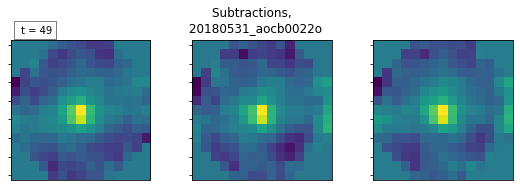

In [100]:
mat_1 = center_avg -  np.average(center_avg[0:199], axis = 0)
mat_2 = center_avg - np.average(center_avg[800:800+199], axis = 0)
mat_3 = center_avg - np.average(center_avg, axis = 0)

gif_3_mat(center_avg, mat_2, mat_3, 50, title = f"Subtractions, \n {pull_data.name}", out_file='out2.gif', scale_v = True, label_1="First 200", label_2="Last 200", label_3="all")

#### P.S. are presubtraction sensitive to order?
 => check out test/test_sub

In [ ]:
## EXTRA: background averages over a night compare? Over multiple nights?

In [5]:
p_file = "/home/emcewen/out/20180531/fits/20180531_aocb0022o_tmax1000_tts.fits"

# pull file 
pull_data = Cor.Correlator("", "", "", f_file = p_file)

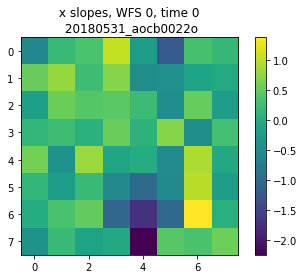

In [27]:
x_slopes = pull_data.x_slopes

plt.imshow(x_slopes[0][0])
plt.title(f" x slopes, WFS 0, time 0 \n {pull_data.name}")
plt.colorbar()

(4, 5000, 8, 8)

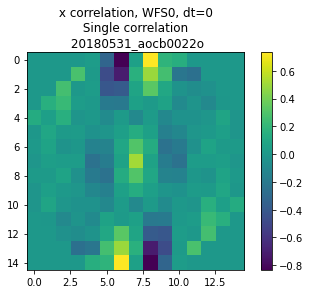

In [28]:
mask = Cor.mask_8_8_center

a_corr_test  = cc.td_auto_corr(x_slopes[0][:2], 1, mask) 

plt.imshow(a_corr_test[0])
plt.title(f" x correlation, WFS0, dt=0 \n Single correlation \n {pull_data.name}")
plt.colorbar()

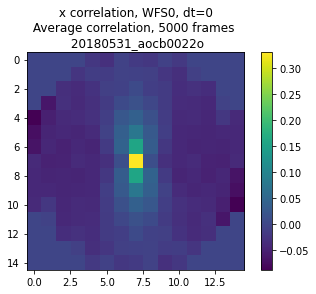

In [34]:
a_corr_test  = cc.td_auto_corr(x_slopes[0], 1, mask) 

plt.imshow(a_corr_test[0])
plt.title(f" x correlation, WFS0, dt=0 \n Average correlation, {x_slopes.shape[1]} frames  \n {pull_data.name}")
plt.colorbar()

Text(0.5, 1.0, ' x correlation, WFS0 \n Single correlation \n 20180531_aocb0022o')

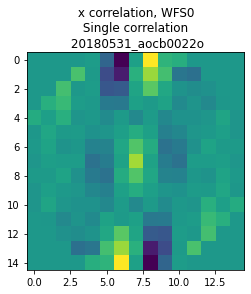

In [22]:
plt.imshow(a_corr_test[0])
plt.title(f" x correlation, WFS0 \n Single correlation \n {pull_data.name}")